<a href="https://colab.research.google.com/github/Sadanand-666/Automated-Medicine-Classification-Using-Deep-Convolutional-Neural-Networks/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Training VGG19 model for automate medicne Recognition

Using device: cuda
Epoch [1/25] - Loss: 1.2983 - Acc: 46.72% - Val Loss: 0.9777 - Val Acc: 59.38% - Time: 220.62 sec
Epoch [2/25] - Loss: 0.8995 - Acc: 66.38% - Val Loss: 0.6871 - Val Acc: 77.43% - Time: 221.35 sec
Epoch [3/25] - Loss: 0.7283 - Acc: 74.00% - Val Loss: 0.5760 - Val Acc: 79.10% - Time: 220.97 sec
Epoch [4/25] - Loss: 0.6179 - Acc: 78.35% - Val Loss: 0.4832 - Val Acc: 83.61% - Time: 221.61 sec
Epoch [5/25] - Loss: 0.5304 - Acc: 80.20% - Val Loss: 0.4331 - Val Acc: 85.99% - Time: 220.94 sec
Epoch [6/25] - Loss: 0.4627 - Acc: 84.62% - Val Loss: 0.4049 - Val Acc: 86.94% - Time: 220.31 sec
Epoch [7/25] - Loss: 0.4067 - Acc: 87.04% - Val Loss: 0.3478 - Val Acc: 88.36% - Time: 223.08 sec
Epoch [8/25] - Loss: 0.3517 - Acc: 89.60% - Val Loss: 0.3246 - Val Acc: 90.50% - Time: 220.86 sec
Epoch [9/25] - Loss: 0.3412 - Acc: 88.96% - Val Loss: 0.3014 - Val Acc: 91.45% - Time: 221.32 sec
Epoch [10/25] - Loss: 0.3330 - Acc: 88.46% - Val Loss: 0.2875 - Val Acc: 91.69% - Time: 219.64 sec


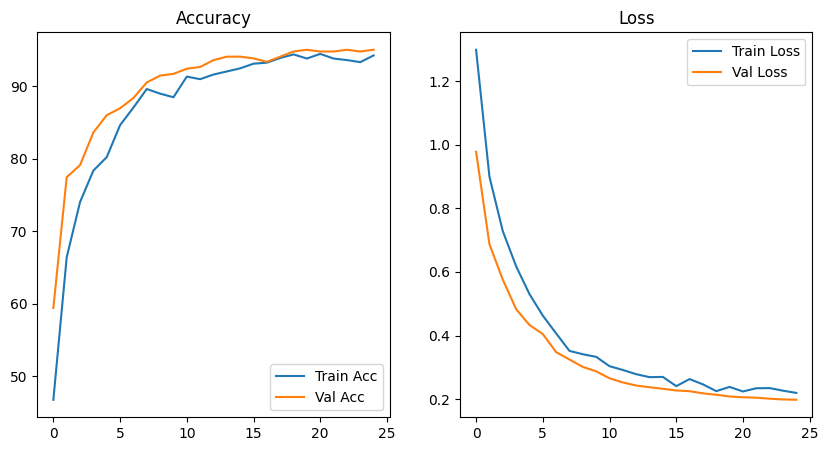

In [ ]:
# ✅ Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import time

# ✅ Check GPU Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define PyTorch Transforms for Regular Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Define Albumentations-based Augmentation

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from PIL import Image

class AlbumentationsTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.Resize(256, 256),  # Resize first
            A.RandomCrop(224, 224),  # Crop
            A.HorizontalFlip(p=0.5),
            A.Affine(scale=(0.8, 1.2), rotate=(-20, 20), translate_percent=(0.1, 0.1)),  # Replacing ShiftScaleRotate
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        augmented = self.transform(image=img)
        return augmented['image']




from torch.utils.data import Dataset
from torchvision import datasets

class AlbumentationsDataset(Dataset):
    def __init__(self, root, transform):
        self.dataset = datasets.ImageFolder(root=root)  # Load dataset
        self.transform = transform  # Apply Albumentations
        self.classes = self.dataset.classes  # Store class names explicitly

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = self.transform(img)  # Apply Albumentations
        return img, label



# ✅ Dataset Paths
train_dir = "/content/drive/MyDrive/Dataset/medicine_data/Trian"
test_dir = "/content/drive/MyDrive/Dataset/medicine_data/Test"

# ✅ Load Datasets Using Custom Wrapper
train_dataset = AlbumentationsDataset(train_dir, AlbumentationsTransform())
test_dataset = AlbumentationsDataset(test_dir, AlbumentationsTransform())

# ✅ Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# ✅ Load Pretrained VGG-19 Model
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

# ✅ Freeze Feature Extractor Layers (For Transfer Learning)
for param in model.features.parameters():
    param.requires_grad = False

# ✅ Modify Classifier with Dropout for Better Performance
num_features = model.classifier[0].in_features  # Get the correct input size (25088)

model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),  # Change 4096 → num_features
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(train_dataset.classes))  # Keep the final output as num_classes
)

# ✅ Move Model to GPU
model = model.to(device)

# ✅ Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ✅ Lists for Tracking Training Progress
train_losses, val_losses, train_acc, val_acc = [], [], [], []
epoch_times, y_true, y_probs = [], [], []

# ✅ Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=25):
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        running_loss, correct, total = 0.0, 0, 0
        epoch_true, epoch_probs = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            epoch_true.extend(labels.cpu().numpy())
            epoch_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        y_true.extend(epoch_true)
        y_probs.extend(epoch_probs)

        # ✅ Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        val_acc_value = 100 * correct / total
        val_losses.append(val_loss)
        val_acc.append(val_acc_value)

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc_value:.2f}% - Time: {epoch_times[-1]:.2f} sec")

        scheduler.step()

    total_end_time = time.time()
    print(f"Total Training Time: {total_end_time - total_start_time:.2f} sec")

# ✅ Train the Model
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=25)

# ✅ Evaluate the Model
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate(model, test_loader)

# ✅ Save the Trained Model
torch.save(model.state_dict(), "vgg19_best_model.pth")
print("Model saved successfully!")

# ✅ Plot Accuracy and Loss Curves
def plot_graphs():
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_graphs()


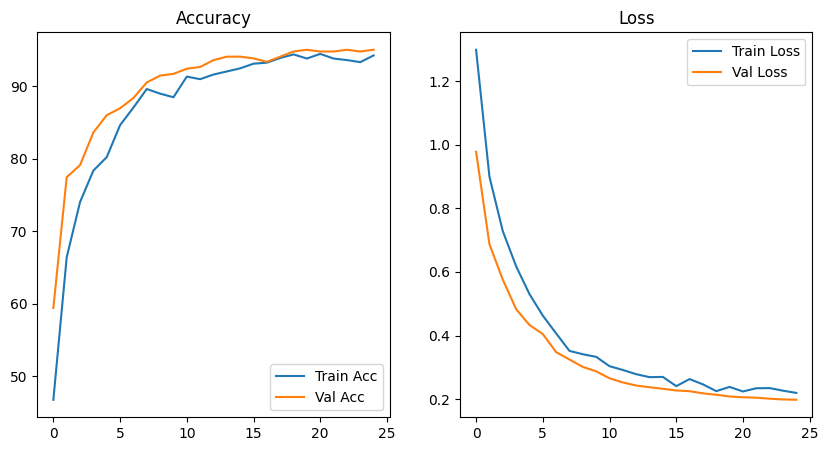

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools

# ✅ 1. Plot Smoothed Accuracy and Loss Graphs
def plot_smoothed_graphs():
    from scipy.ndimage import gaussian_filter1d

    smoothed_train_acc = gaussian_filter1d(train_acc, sigma=1)
    smoothed_val_acc = gaussian_filter1d(val_acc, sigma=1)
    smoothed_train_loss = gaussian_filter1d(train_losses, sigma=1)
    smoothed_val_loss = gaussian_filter1d(val_losses, sigma=1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(smoothed_train_acc, label="Train Acc (Smoothed)", linestyle="--")
    plt.plot(smoothed_val_acc, label="Val Acc (Smoothed)", linestyle="--")
    plt.title("Smoothed Accuracy Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(smoothed_train_loss, label="Train Loss (Smoothed)", linestyle="--")
    plt.plot(smoothed_val_loss, label="Val Loss (Smoothed)", linestyle="--")
    plt.title("Smoothed Loss Curve")
    plt.legend()

    plt.show()





# ✅ Call All Graphs for Better Visualization
plot_graphs()



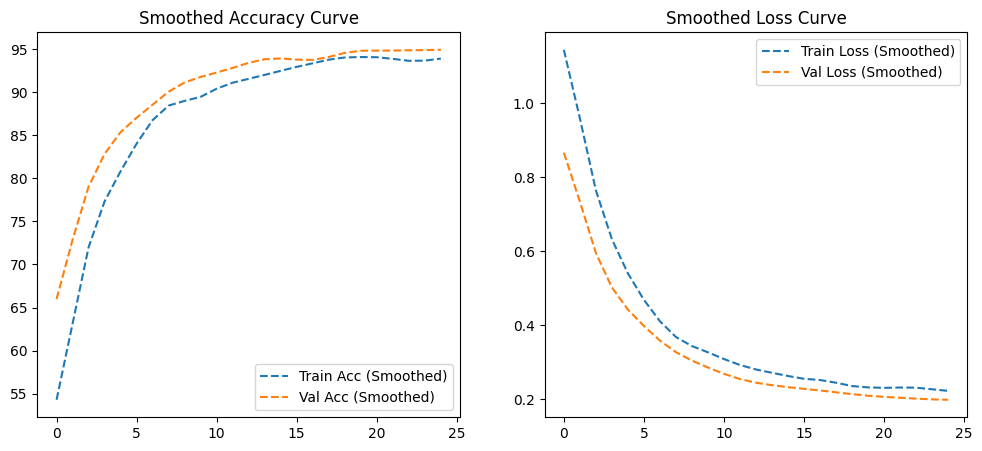

In [ ]:
plot_smoothed_graphs()

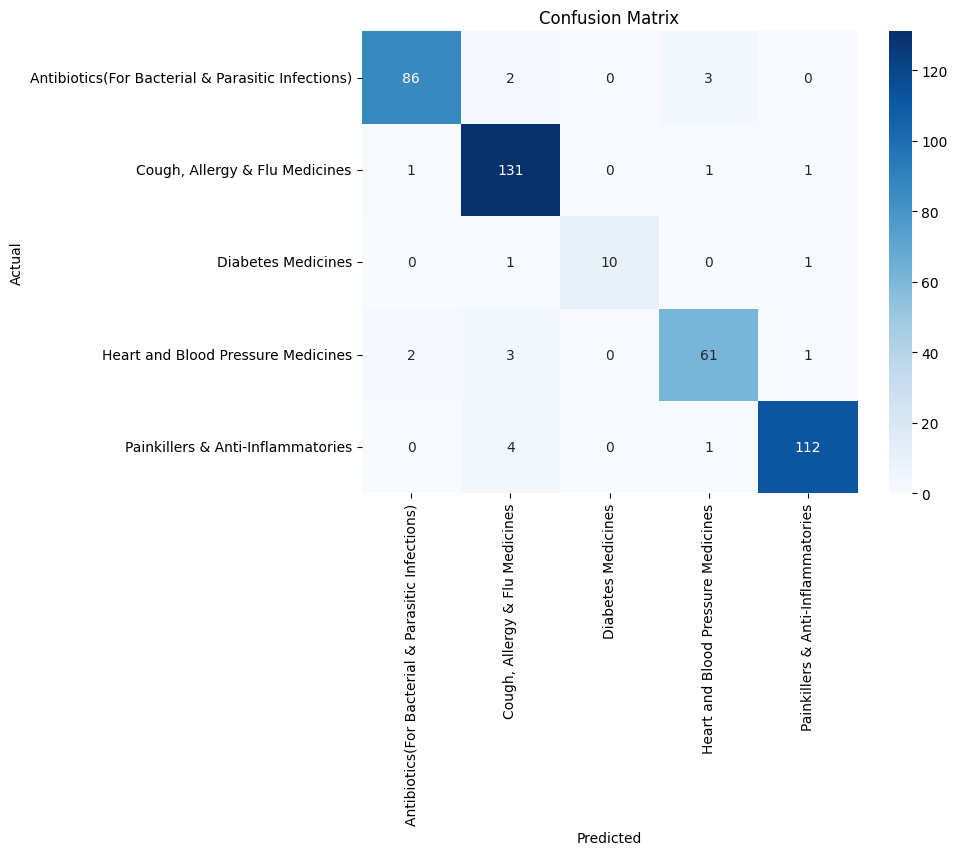

In [ ]:
# ✅ 3. Plot Confusion Matrix
def plot_confusion_matrix():
    y_pred = []
    y_true_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(y_true_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix()

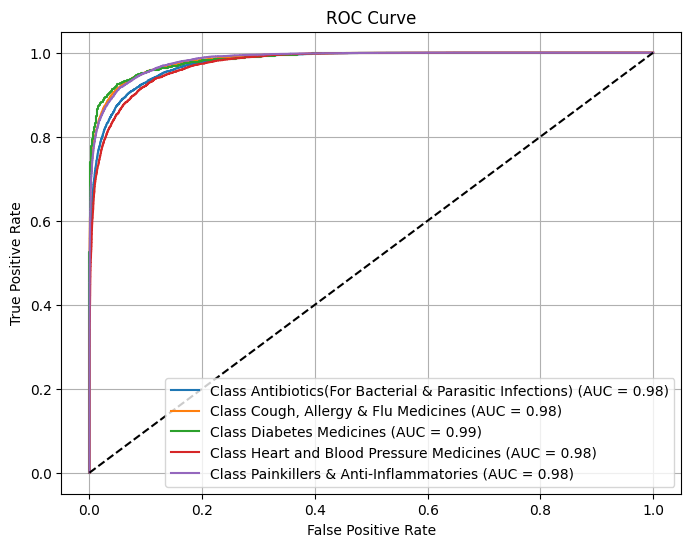

In [ ]:
# ✅ 4. Plot ROC Curve (for multi-class, one-vs-rest approach)
def plot_roc_curve():
    y_true_np = np.array(y_true)
    y_probs_np = np.array(y_probs)

    plt.figure(figsize=(8, 6))

    for i in range(len(train_dataset.classes)):
        fpr, tpr, _ = roc_curve(y_true_np == i, y_probs_np[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {train_dataset.classes[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

plot_roc_curve()

In [ ]:
from sklearn.metrics import classification_report

# ✅ Evaluate the Model with F1-Score
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # ✅ Compute F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=4))

# ✅ Run Evaluation
evaluate(model, test_loader)
